In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [95]:
data = 'dataset/df_data_engineered.csv'
index_col = 0
df = pd.read_csv(data, sep=',', index_col=index_col)

pd.set_option('display.max_columns', None)

In [96]:
df['gender'] = df['gender'].astype('category')
df['nationality'] = df['nationality'].astype('category')
df['country'] = df['country'].astype('category')
df['region'] = df['region'].astype('category')
df['province'] = df['province'].astype('category')
df['birth_place'] = df['birth_place'].astype('category')
df['birth_date'] = pd.to_datetime(df['birth_date'], errors='coerce')
df['active_start'] = pd.to_datetime(df['active_start'], errors='coerce')
df['description'] = df['description'].astype('string')


In [97]:
df['id_artist'] = df['id_artist'].astype('category')
df['id_album'] = df['id_album'].astype('category')
df['language'] = df['language'].astype('category')
df['album_type'] = df['album_type'].astype('category')
df['popularity'] = pd.to_numeric(df['popularity'], errors = 'coerce').astype('Int64')
df['n_sentences'] = df['n_sentences'].astype('Int64')
df['n_tokens'] = df['n_tokens'].astype('Int64')
df['disc_number'] = df['disc_number'].astype('Int64')
df['track_number'] = df['track_number'].astype('Int64')
df['explicit'] = df['explicit'].astype('bool')
df['name_artist'] = df['name_artist'].astype('string')
df['title'] = df['title'].astype('string')
df['album'] = df['album'].astype('string')
df['album_image'] = df['album_image'].astype('string')
df['lyrics'] = df['lyrics'].astype('string')
df['correct_release_date'] = pd.to_datetime(df['correct_release_date'], errors='coerce')

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11166 entries, TR934808 to TR552777
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id_artist                      11166 non-null  category      
 1   name_artist                    11166 non-null  string        
 2   title                          11166 non-null  string        
 3   featured_artists               11166 non-null  object        
 4   language                       11032 non-null  category      
 5   swear_IT                       11166 non-null  int64         
 6   swear_EN                       11166 non-null  int64         
 7   swear_IT_words                 11166 non-null  object        
 8   swear_EN_words                 11166 non-null  object        
 9   n_sentences                    10959 non-null  Int64         
 10  n_tokens                       10955 non-null  Int64         
 11  tokens_per

In [ ]:
# Select the final, cleaned, and engineered numerical features
FEATURE_COLS = [
    # Linguistic & Rate Features
    'tokens_per_sent', 'avg_token_per_clause', 'swear_rate', 'tokens_per_minute', 'n_sentences', 'n_tokens', 'swear_IT', 'swear_EN', 'lexical_density',
    
    # Audio/Acoustic Features (Using a representative sample)
    'bpm', 'centroid', 'rolloff', 'flux', 'rms', 'spectral_complexity', 'pitch', 'flatness',
    
    # Aggregated/Relative Popularity Features
    'popularity', 'mean_popularity_artist', 'mean_popularity_album', 
    'song_pop_vs_region_avg_zscore', 'release_gap_zscore', 
    'rank_by_year'
]

#FEATURE_COLS = df.select_dtypes(include=np.number).columns

In [116]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
X = scaler.fit_transform(df[FEATURE_COLS].values)

TypeError: float() argument must be a string or a real number, not 'NAType'

In [100]:
data_for_clustering = df[FEATURE_COLS].dropna()
print(f"Original rows: {len(df)}. Rows for clustering after dropping NaNs: {len(data_for_clustering)}")

Original rows: 11166. Rows for clustering after dropping NaNs: 7409


In [101]:
from sklearn.preprocessing import StandardScaler

# Create the index mask for later mapping the clusters back to df
original_indices = data_for_clustering.index

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(data_for_clustering)

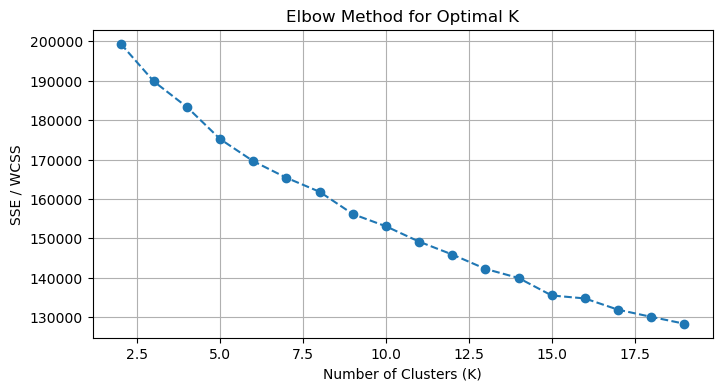

In [102]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
k_range = range(2, 20) # Testing K from 2 to 10

for k in k_range:
    # Set n_init to 'auto' for modern sklearn versions
    kmeans = KMeans(n_clusters=k, random_state=42, n_init= 10) 
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_) # inertia_ is the WCSS

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE / WCSS')
plt.grid(True)
plt.show() 
#

In [103]:
# --- STEP 4A: Train the final model ---
optimal_k = 6 # Replace with the K you chose from the plot

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_final.fit(X_scaled)

# --- STEP 4B: Assign the labels back to the original DataFrame ---

# Create a temporary Series with the cluster labels and the corresponding index
cluster_labels_series = pd.Series(kmeans_final.labels_, index=original_indices)

# Assign the labels back to the main DataFrame
df['Cluster'] = np.nan # Initialize the column with NaN
df.loc[original_indices, 'Cluster'] = cluster_labels_series

# Convert the Cluster column to a category or Int64
df['Cluster'] = df['Cluster'].astype('Int64')

print(f"\n✅ Clustering complete! Data is grouped into {optimal_k} clusters.")
print(df['Cluster'].value_counts(dropna=False))


✅ Clustering complete! Data is grouped into 6 clusters.
Cluster
<NA>    3757
0       2002
2       1864
4       1765
1       1444
3        324
5         10
Name: count, dtype: Int64


In [104]:
# Analyze the cluster centroids using the original feature names
cluster_profiles = df.groupby('Cluster')[FEATURE_COLS].mean()

print("\n--- Cluster Profile Analysis (Mean Feature Values) ---")
print(cluster_profiles.T)


--- Cluster Profile Analysis (Mean Feature Values) ---
Cluster                                    0              1              2  \
swear_IT                             2.88961       1.126731       1.208155   
swear_EN                            0.493506        0.25831       0.345494   
n_sentences                         70.81968      43.795706      50.811695   
n_tokens                          592.141858      359.58518     415.190987   
tokens_per_sent                     8.495659       8.748315       8.328452   
char_per_tok                        4.007374       4.059397       3.979576   
lexical_density                     0.510279       0.501209       0.505805   
avg_token_per_clause                 7.22559       7.878385       7.171702   
bpm                                110.74529     112.485014     119.602935   
centroid                            0.153574        0.12068       0.126198   
rolloff                          1915.714295    1374.836655     1389.47137   
flux    

In [105]:
from sklearn.decomposition import PCA
import pandas as pd # Import needed for the result DataFrame

# 1. Get the scaled data and the corresponding cluster labels
# Assuming X_scaled contains your scaled features and 'Cluster' is assigned to df

# Drop rows where cluster assignment failed (due to missing values in the original features)
clustered_df = df.dropna(subset=['Cluster']).copy()
X_scaled_clustered = StandardScaler().fit_transform(clustered_df[FEATURE_COLS])
cluster_labels = clustered_df['Cluster'].astype(int) # Ensure labels are integer

# 2. Initialize and run PCA to reduce the data to 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled_clustered)

# 3. Create a DataFrame for plotting
pca_df = pd.DataFrame(
    data=principal_components, 
    columns=['PC1', 'PC2']
)

# Add the cluster labels back to the plotting DataFrame
pca_df['Cluster'] = cluster_labels.values

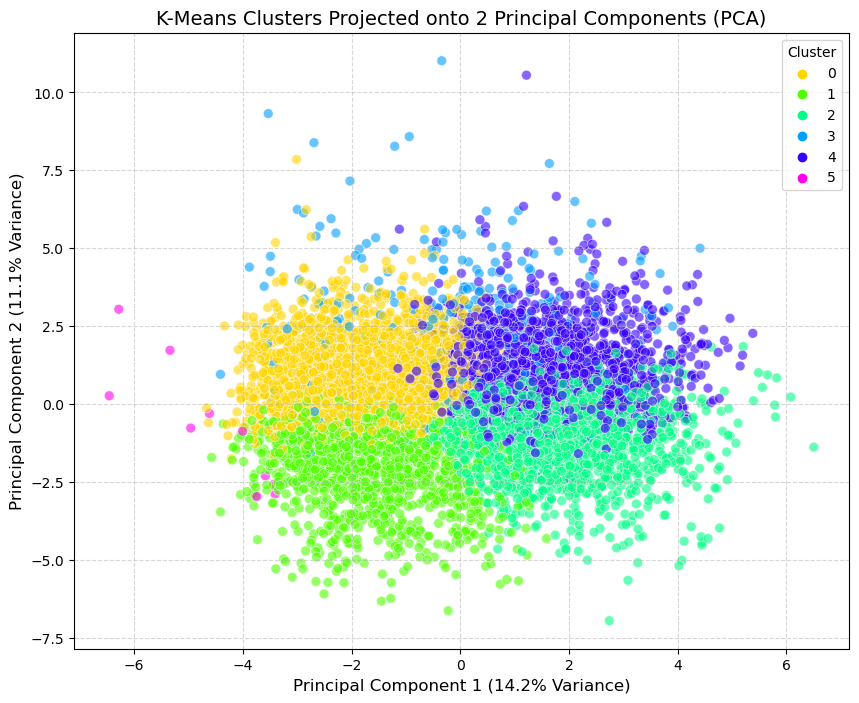

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))

# Use seaborn scatterplot, coloring points by the 'Cluster' column
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='Cluster', 
    data=pca_df,
    palette=sns.color_palette("hsv", n_colors=pca_df['Cluster'].nunique()), # Use distinct colors
    legend="full",
    alpha=0.6,
    s=50
)

plt.title('K-Means Clusters Projected onto 2 Principal Components (PCA)', fontsize=14)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% Variance)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% Variance)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [107]:
# Assuming 'pca_df' (with columns PC1, PC2, Cluster) is available from your PCA step.

# Group data to find the centroid (mean) and standard deviation (std) for each cluster
cluster_stats = pca_df.groupby('Cluster')[['PC1', 'PC2']].agg(['mean', 'std']).fillna(0) # fillna handles single-point clusters

# Extract Centroids
centroids = cluster_stats.loc[:, 'PC1']['mean'].values
centroid_df = cluster_stats.loc[:, (slice(None), 'mean')]
centroid_df.columns = centroid_df.columns.droplevel(1) # Drop the 'mean' level

# Extract Standard Deviations
std_devs = cluster_stats.loc[:, (slice(None), 'std')]
std_devs.columns = std_devs.columns.droplevel(1) # Drop the 'std' level

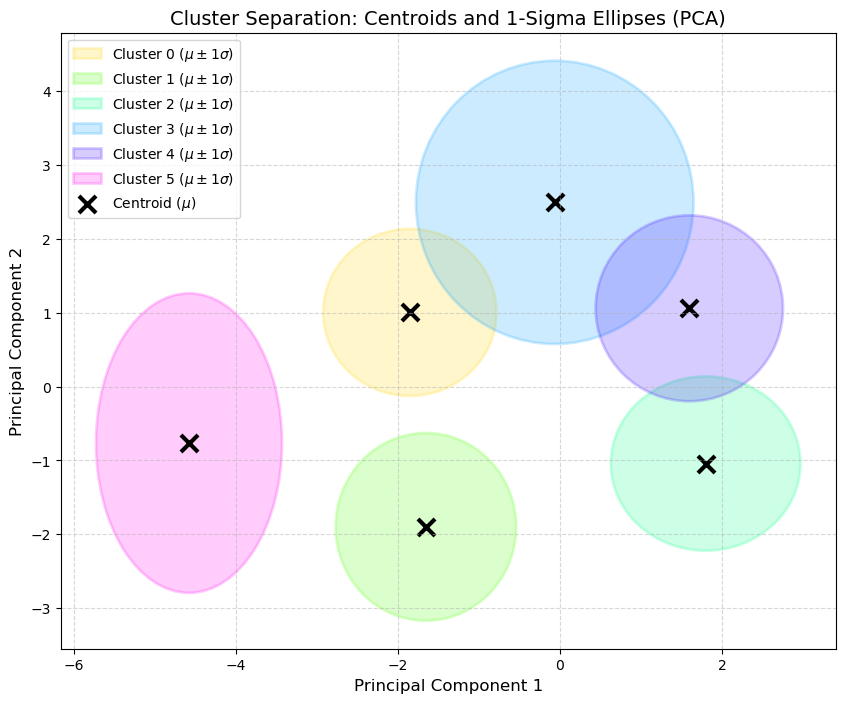

In [108]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))

# Get the color palette used for the clusters
num_clusters = pca_df['Cluster'].nunique()
palette = sns.color_palette("hsv", n_colors=num_clusters)

# Plot the Ellipses (1 Standard Deviation boundary)
for cluster_id in range(num_clusters):
    # Get centroid coordinates and std dev for the current cluster
    center = (centroid_df.loc[cluster_id, 'PC1'], centroid_df.loc[cluster_id, 'PC2'])
    std_pc1 = std_devs.loc[cluster_id, 'PC1']
    std_pc2 = std_devs.loc[cluster_id, 'PC2']
    color = palette[cluster_id]

    # Create the ellipse object
    # The width is 2*std_pc1, and height is 2*std_pc2 to cover +/- 1 standard deviation
    ellipse = patches.Ellipse(
        center, 
        width=2*std_pc1, 
        height=2*std_pc2,
        angle=0, # Assuming PC axes are orthogonal
        edgecolor=color, 
        facecolor=color,
        alpha=0.2, # Make the ellipse transparent
        linewidth=2,
        label=f'Cluster {cluster_id} ($\mu \pm 1\sigma$)'
    )
    ax.add_patch(ellipse)

# Plot the Centroids on top
ax.scatter(
    centroid_df['PC1'], 
    centroid_df['PC2'], 
    color='black', 
    marker='x', 
    s=150, 
    linewidths=3,
    label='Centroid ($\mu$)'
)

# Set plot details
ax.set_title('Cluster Separation: Centroids and 1-Sigma Ellipses (PCA)', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)

# Ensure the plot limits show all ellipses
ax.autoscale_view()
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.show()

In [109]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
tsne_components = tsne.fit_transform(X_scaled_clustered)

# 4. Create a DataFrame for plotting
tsne_df = pd.DataFrame(
    data=tsne_components, 
    columns=['TSNE_Component_1', 'TSNE_Component_2']
)

# Add the cluster labels back
tsne_df['Cluster'] = cluster_labels.values

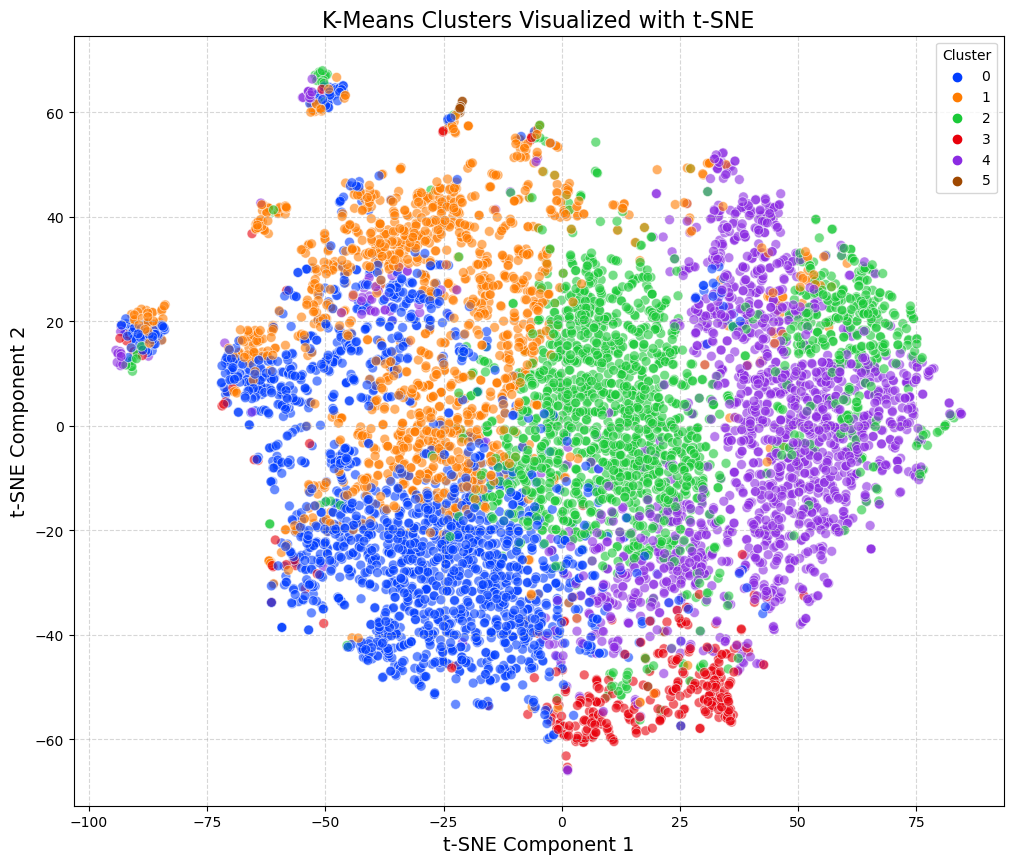

In [110]:
plt.figure(figsize=(12, 10))

# Use seaborn scatterplot, coloring points by the 'Cluster' column
sns.scatterplot(
    x='TSNE_Component_1', 
    y='TSNE_Component_2', 
    hue='Cluster', 
    data=tsne_df,
    palette=sns.color_palette("bright", n_colors=tsne_df['Cluster'].nunique()), 
    legend="full",
    alpha=0.6,
    s=50
)

plt.title('K-Means Clusters Visualized with t-SNE', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

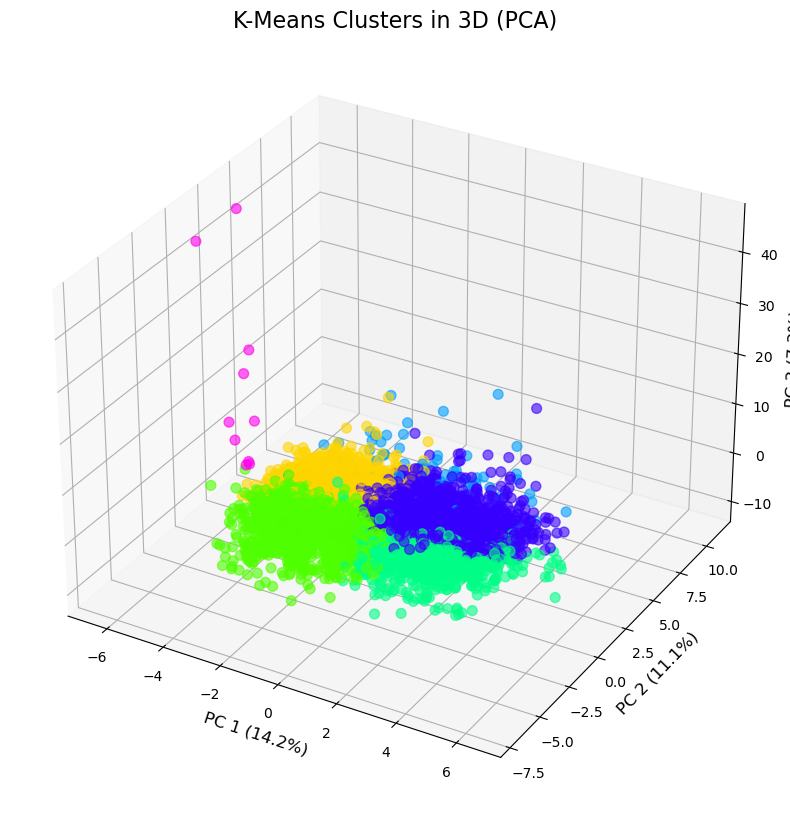

In [111]:
# 1. Run PCA for 3 components
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_scaled_clustered)

# 2. Create DataFrame for plotting
pca_df = pd.DataFrame(
    data=principal_components, 
    columns=['PC1', 'PC2', 'PC3']
)
pca_df['Cluster'] = cluster_labels.values


# 3. 3D Plotting
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Get distinct colors
num_clusters = pca_df['Cluster'].nunique()
palette = sns.color_palette("hsv", n_colors=num_clusters)
colors = [palette[c] for c in pca_df['Cluster']]

# Scatter plot
ax.scatter(
    pca_df['PC1'], 
    pca_df['PC2'], 
    pca_df['PC3'], 
    c=colors, 
    marker='o', 
    s=50,
    alpha=0.6
)

# Set labels with explained variance
ax.set_title('K-Means Clusters in 3D (PCA)', fontsize=16)
ax.set_xlabel(f'PC 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax.set_ylabel(f'PC 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax.set_zlabel(f'PC 3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=12)

plt.show()

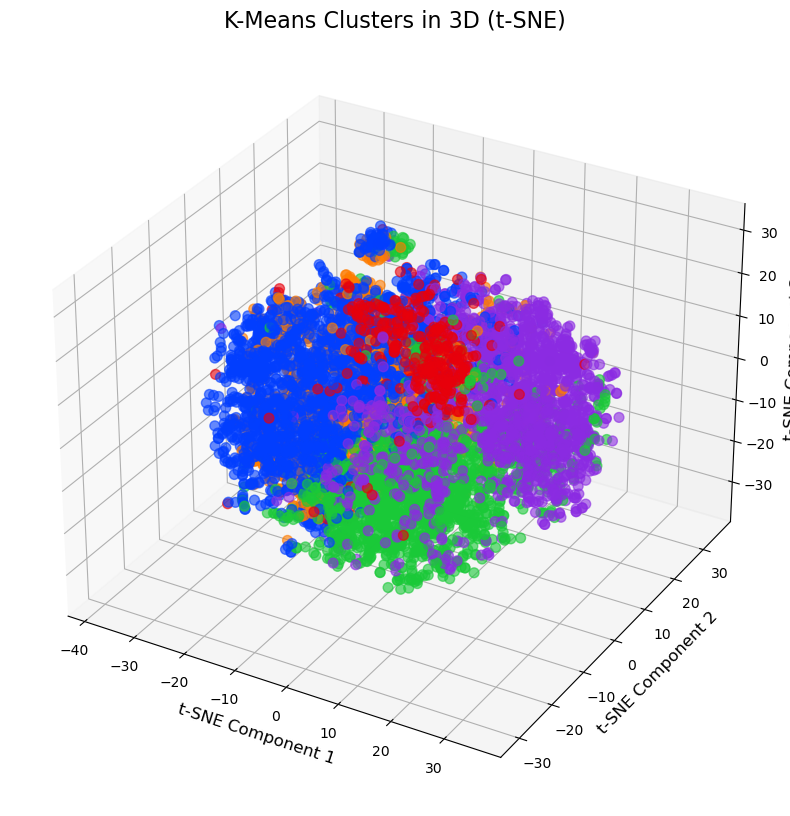

In [112]:
tsne = TSNE(n_components=3, perplexity=30, random_state=42, n_jobs=-1)
tsne_components = tsne.fit_transform(X_scaled_clustered)

# 2. Create DataFrame for plotting
tsne_df = pd.DataFrame(
    data=tsne_components, 
    columns=['TSNE_C1', 'TSNE_C2', 'TSNE_C3']
)
tsne_df['Cluster'] = cluster_labels.values


# 3. 3D Plotting
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Get distinct colors
num_clusters = tsne_df['Cluster'].nunique()
palette = sns.color_palette("bright", n_colors=num_clusters)
colors = [palette[c] for c in tsne_df['Cluster']]

# Scatter plot
ax.scatter(
    tsne_df['TSNE_C1'], 
    tsne_df['TSNE_C2'], 
    tsne_df['TSNE_C3'], 
    c=colors, 
    marker='o', 
    s=50,
    alpha=0.6
)

ax.set_title('K-Means Clusters in 3D (t-SNE)', fontsize=16)
ax.set_xlabel('t-SNE Component 1', fontsize=12)
ax.set_ylabel('t-SNE Component 2', fontsize=12)
ax.set_zlabel('t-SNE Component 3', fontsize=12)

plt.show()